In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
ratings = pd.read_table('movielens-10m/ratings.dat', delimiter='::', header=None)
movies = pd.read_table('movielens-10m/movies.dat', delimiter='::', header=None)
tags = pd.read_table('movielens-10m/tags.dat', delimiter='::', header=None)

In [3]:
ratings_cols = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
movies_cols = ['Movie_ID', 'Title', 'Genres']

In [4]:
movies.columns = movies_cols
ratings.columns = ratings_cols

In [5]:
movies['Movie_ID_Marker'] = movies.index

In [6]:
movies.head()

,Movie_ID,Title,Genres,Movie_ID_Marker
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [7]:
train_df = movies.merge(ratings, on='Movie_ID')

In [8]:
train_df.drop(columns=['Title', 'Genres'], inplace=True)
train_df.drop(columns=['Timestamp'], inplace=True)

In [9]:
train_df = train_df.sort_values( by=['User_ID'], ascending=True )
train_df = train_df.reset_index()
train_df.drop(columns=['index'], inplace=True)

In [10]:
train_df.nunique()

Movie_ID           10677
Movie_ID_Marker    10677
User_ID            69878
Rating                10
dtype: int64

In [11]:
print(train_df.Movie_ID.max())
print(ratings.User_ID.max())

65133
71567


In [12]:
np.sum(train_df['User_ID'] > 69878)

250626

In [13]:
np.sum(train_df['Movie_ID_Marker'] > 10677)

12

In [14]:
users = pd.DataFrame()

In [15]:
users['User_ID'] = train_df['User_ID']

In [16]:
users.drop_duplicates(subset='User_ID', keep='first', inplace=True)

In [17]:
users.reset_index(inplace=True)
users.drop(columns='index', inplace=True)

In [18]:
users['User_ID_Marker'] = users.index

In [19]:
train_df = users.merge(train_df, on='User_ID')

In [20]:
train_df.head()

,User_ID,User_ID_Marker,Movie_ID,Movie_ID_Marker,Rating
0,1,0,480,476,5.0
1,1,0,292,289,5.0
2,1,0,466,462,5.0
3,1,0,420,416,5.0
4,1,0,616,610,5.0


In [21]:
from scipy import sparse
# 建立稀疏矩阵
# coo_matrix((data, (i, j)), [shape=(M, N)])
# to construct from three arrays:
# data[:] 矩阵内的值
#    i[:] 矩阵行的索引
#    j[:] 矩阵列的索引

# 矩阵内的值，/ 5.0让所有评分都介于0-1之间
data = train_df['Rating'] / 5.0

i = train_df['User_ID_Marker']
j = train_df['Movie_ID_Marker']

ratings_train = sparse.coo_matrix( (data, (i,j)) ).tocsr()
ratings_train.shape

(69878, 10681)

In [22]:
def gibbs(proba):
# gibbs sampling: e.g. given proba=0.3
# sample u ~ uniform[0, 1]
# if u < 0.3 then return 1; else 0
    return tf.nn.relu(tf.sign(proba - tf.random_uniform(tf.shape(proba))))

In [48]:
n_visible = ratings_train.shape[1]
n_hidden = 32
lr = 0.1
graph = tf.Graph()
with graph.as_default():
    visible = tf.placeholder(tf.float32, [None, n_visible])
    W = tf.Variable(tf.truncated_normal([n_visible, n_hidden],
                                    stddev=0.1), dtype=tf.float32)
    v_bias = tf.Variable(tf.zeros([n_visible]), dtype=tf.float32)
    h_bias = tf.Variable(tf.zeros([n_hidden]), dtype=tf.float32)

    
    v_2_h_1 = tf.nn.sigmoid(tf.matmul(visible, W) + h_bias)
        # hidden to visible pass
        # sample h ~ P(h|v) and feed it to visible
    h_2_v_1 = tf.nn.sigmoid(tf.matmul(gibbs(v_2_h_1), tf.transpose(W))
                                + v_bias)
        # second visible to hidden pass
        # sample v ~ P(v|h) and feed it to hidden
    v_2_h_2 = tf.nn.sigmoid(tf.matmul(gibbs(h_2_v_1), W)
                                + h_bias)
        
        # contrastive divergence
    positive_grad = tf.matmul(tf.transpose(visible), v_2_h_1)
    negative_grad = tf.matmul(tf.transpose(h_2_v_1), v_2_h_2)
        

    W_grad = (positive_grad - negative_grad)/tf.to_float(tf.shape(visible)[0])

    v_bias_grad = tf.reduce_mean(visible - h_2_v_1, 0)

    h_bias_grad = tf.reduce_mean(v_2_h_1 - v_2_h_2, 0)

    update_W = W.assign(W + lr * W_grad)
    update_v_bias = v_bias.assign(v_bias + lr * v_bias_grad)
    update_h_bias = h_bias.assign(h_bias + lr * h_bias_grad)

    updates = [update_W, update_v_bias, update_h_bias]

    v_2_h = tf.nn.sigmoid(tf.matmul(visible, W)
                              + h_bias)
    h_2_v = tf.nn.sigmoid(tf.matmul(v_2_h, tf.transpose(W)) 
                              + v_bias)
    rmse = tf.sqrt( tf.reduce_mean( tf.square(visible-h_2_v) ) )
    
    init = tf.global_variables_initializer()

In [49]:
ratings_train.shape

(69878, 10681)

In [50]:
n_epoch = 200
batch_size = 64
train_data = ratings_train[:60000]
val_data = ratings_train[60000:].todense()
print(train_data.shape)
print(val_data.shape)

(60000, 10681)
(9878, 10681)


In [51]:
sess = tf.Session(graph=graph)
sess.run(init)
errors = []
for epoch in tqdm(range(n_epoch)):
    for start in range(0, train_data.shape[0]-batch_size, batch_size):
        end = start + batch_size
        batch = train_data[start:end].todense()
        sess.run(updates, feed_dict={visible: batch})
    error = sess.run(rmse, feed_dict={visible: val_data})
    errors.append(error)
    print('epoch: {}, RMSE: {:.8f}'.format(epoch, error))

epoch: 0, RMSE: 0.07515521
epoch: 1, RMSE: 0.07357125
epoch: 2, RMSE: 0.07242349
epoch: 3, RMSE: 0.07172824
epoch: 4, RMSE: 0.07134455
epoch: 5, RMSE: 0.07104906
epoch: 6, RMSE: 0.07082830
epoch: 7, RMSE: 0.07064639
epoch: 8, RMSE: 0.07049112
epoch: 9, RMSE: 0.07035851
epoch: 10, RMSE: 0.07026044
epoch: 11, RMSE: 0.07017089
epoch: 12, RMSE: 0.07008664
epoch: 13, RMSE: 0.07001903
epoch: 14, RMSE: 0.06994046
epoch: 15, RMSE: 0.06987498
epoch: 16, RMSE: 0.06981075
epoch: 17, RMSE: 0.06975324
epoch: 18, RMSE: 0.06970745
epoch: 19, RMSE: 0.06965053
epoch: 20, RMSE: 0.06960358
epoch: 21, RMSE: 0.06957041
epoch: 22, RMSE: 0.06953157
epoch: 23, RMSE: 0.06949876
epoch: 24, RMSE: 0.06946728
epoch: 25, RMSE: 0.06944142
epoch: 26, RMSE: 0.06941398
epoch: 27, RMSE: 0.06939097
epoch: 28, RMSE: 0.06937367
epoch: 29, RMSE: 0.06935535
epoch: 30, RMSE: 0.06934266
epoch: 31, RMSE: 0.06931858
epoch: 32, RMSE: 0.06930778
epoch: 33, RMSE: 0.06929532
epoch: 34, RMSE: 0.06927110
epoch: 35, RMSE: 0.06925617
ep

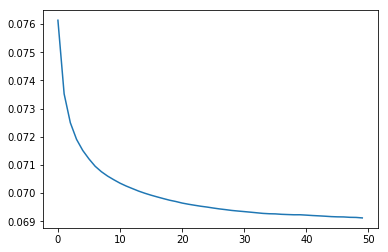

In [27]:
plt.plot(errors)
plt.show()

In [87]:
pred_user = ratings_train[60007].todense()
pred_user
movies_recommendations = movies.copy()

In [88]:
pred_movies = sess.run(h_2_v, feed_dict={visible: pred_user})

In [89]:
np.sum(pred_movies >= .5)

195

In [90]:
movies_recommendations['rating'] = pred_user.T * 5
movies_recommendations.sort_values( by=['rating'], ascending=False ).drop(columns=['Movie_ID'])

,Title,Genres,Movie_ID_Marker,rating
1016,"Sound of Music, The (1965)",Musical|Romance,1016,5.0
471,In the Name of the Father (1993),Drama,471,5.0
1164,Strictly Ballroom (1992),Comedy|Romance,1164,5.0
1075,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,1075,5.0
1074,Sophie's Choice (1982),Drama,1074,5.0
1528,Men in Black (1997),Action|Comedy|Sci-Fi,1528,5.0
450,"Firm, The (1993)",Drama|Thriller,450,5.0
453,"Fugitive, The (1993)",Thriller,453,5.0
1169,One Flew Over the Cuckoo's Nest (1975),Comedy|Drama,1169,5.0
246,Immortal Beloved (1994),Drama|Romance,246,5.0


In [91]:
movies_recommendations['predict'] = np.ceil(pred_movies.T * 5)
movies_recommendations[movies_recommendations['rating']==0].sort_values( by=['predict'], ascending=False )

,Movie_ID,Title,Genres,Movie_ID_Marker,rating,predict
582,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,582,0.0,5.0
1072,1094,"Crying Game, The (1992)",Drama|Romance|War,1072,0.0,4.0
1181,1207,To Kill a Mockingbird (1962),Drama,1181,0.0,4.0
891,908,North by Northwest (1959),Adventure|Mystery|Thriller,891,0.0,4.0
1154,1177,Enchanted April (1992),Drama|Romance,1154,0.0,4.0
45,46,How to Make an American Quilt (1995),Drama|Romance,45,0.0,4.0
35,36,Dead Man Walking (1995),Crime|Drama,35,0.0,4.0
234,237,Forget Paris (1995),Comedy|Romance,234,0.0,4.0
523,527,Schindler's List (1993),Drama|War,523,0.0,4.0
31,32,12 Monkeys (Twelve Monkeys) (1995),Sci-Fi|Thriller,31,0.0,4.0
